In [2]:
# ライブラリをインポート
import cv2
import os
import sys
import math
from PIL.Image import fromarray
from IPython.display import Image
import matplotlib.pyplot as plt
from pathlib import Path
import copy

# yolov8を読み込む
from ultralytics import YOLO

In [3]:
# yoloのインスタンスを作る
model = YOLO('yolov8x.pt')

In [4]:
# 画像表示用の関数を定義する
def imshow(img):
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

In [5]:
# 動画を読み込む
# 動画は画像の連続だからループで取り込む
video_path = "./video/highway.mp4"
cap = cv2.VideoCapture(video_path)
frame_list = []
ret = True
while ret:
    ret, frame = cap.read()
    if ret:
        frame_list.append(frame)

In [8]:
# fpsを表示する
fps = cap.get(cv2.CAP_PROP_FPS)
fps


21.455488236028117

In [9]:
# 総フレーム数を表示する
len(frame_list)

403

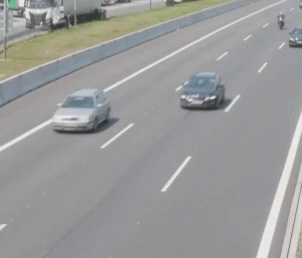

In [10]:
# 51番目のフレームを描画
frame = frame_list[51]
imshow(frame)

In [11]:
ret = model(frame)


0: 576x640 4 cars, 1 motorcycle, 1 truck, 6028.9ms
Speed: 8.6ms preprocess, 6028.9ms inference, 2703.8ms postprocess per image at shape (1, 3, 576, 640)


In [12]:
ret[0].boxes[0].cls[0].item() == 2

True

## 検出

In [13]:
# 検出してみる
results = ret = model(frame)
target = { 2:"car",  5:"bus", 7:"truck", 3:"motorcycle", 1:"bicycle" }
cars = [car for car in results[0].boxes if int(car.cls[0].item()) in target] 


0: 576x640 4 cars, 1 motorcycle, 1 truck, 4973.7ms
Speed: 18.1ms preprocess, 4973.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


In [14]:
cars[0].xyxy

tensor([[ 51.7437,  87.2045, 111.4468, 132.4293]])

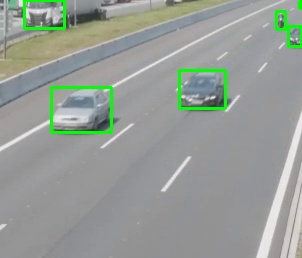

In [15]:
# 検出結果の表示用にコピー
f_view = copy.copy(frame)
for car in cars:
    # bboxは車の左上の座標と右下の座標を持つ
    bbox = {}
    bbox["x1"] = car.xyxy[0][0]
    bbox["y1"] = car.xyxy[0][1]
    bbox["x2"] = car.xyxy[0][2]
    bbox["y2"] = car.xyxy[0][3]
    cv2.rectangle(
        f_view,
        (int(bbox["x1"]), int(bbox["y1"])),
        (int(bbox["x2"]), int(bbox["y2"])),
        color=(0, 255, 0),
        thickness=2,
    )

imshow(f_view)

In [16]:
# 車クラスを作る
class Car:
    def __init__(self, bbox, f):
        self.bbox = bbox
        x1=round(bbox["x1"])
        x2=round(bbox["x2"])
        y1=round(bbox["y1"])
        y2=round(bbox["y2"])
        self.img  = copy.copy(f[y1:y2, x1:x2])
        return
    
    def show(self):
        imshow(self.img)
    
    def compare_by_hist(self, another_car):
        # histgramで比較
        self_hist = cv2.calcHist([self.img], [0], None, [256], [0, 256])
        another_hist = cv2.calcHist([another_car.img], [0], None, [256], [0, 256])
        return 1-cv2.compareHist(self_hist, another_hist, 0)
    
    def compare_by_pos(self, another_car):
        # 位置で比較
        x0 = round((self.bbox["x1"]+self.bbox["x2"])/2)
        y0 = round((self.bbox["y1"]+self.bbox["y2"])/2)
        x1 = round((another_car.bbox["x1"]+another_car.bbox["x2"])/2)
        y1 = round((another_car.bbox["y1"]+another_car.bbox["y2"])/2)
        dx = x1-x0
        dy = y1-y0
        return math.sqrt(dx*dx + dy*dy)
    
    def compare(self, another_car):
        # 2つを組み合わせて比較
        return abs(self.compare_by_hist(another_car) * self.compare_by_pos(another_car))
    
frame.shape

(258, 302, 3)

In [17]:
# 50フレーム目（車が写っているフレーム）の車リストを作る
cars_in_51 =[]
frame = frame_list[51]
results = ret = model(frame)
target = { 2:"car",  5:"bus", 7:"truck", 3:"motorcycle", 1:"bicycle" }
cars = [car for car in results[0].boxes if int(car.cls[0].item()) in target] 
for car in cars:
    bbox = {}
    bbox["x1"] = car.xyxy[0][0].item()
    bbox["y1"] = car.xyxy[0][1].item()
    bbox["x2"] = car.xyxy[0][2].item()
    bbox["y2"] = car.xyxy[0][3].item()
    car = Car(bbox, frame)
    cars_in_51.append(car)


0: 576x640 4 cars, 1 motorcycle, 1 truck, 5043.1ms
Speed: 38.3ms preprocess, 5043.1ms inference, 17.9ms postprocess per image at shape (1, 3, 576, 640)


In [18]:
# 車0と車0を比較する （ふたつの距離）
cars_in_51[0].compare(cars_in_51[0])

0.0

In [19]:
# 車0と車1を比較する 
cars_in_51[0].compare(cars_in_51[1])

37.363979316494174

カウントに入っていく

In [20]:
# カウントする範囲（Y軸のみ）を設定
WINDOW_START=120
WINDOW_END  =180


0: 576x640 7 cars, 7199.3ms
Speed: 19.2ms preprocess, 7199.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 640)


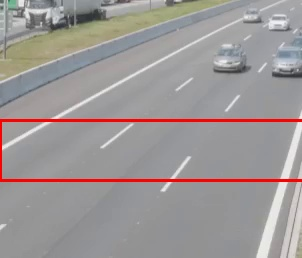


0: 576x640 7 cars, 3553.8ms
Speed: 9.9ms preprocess, 3553.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


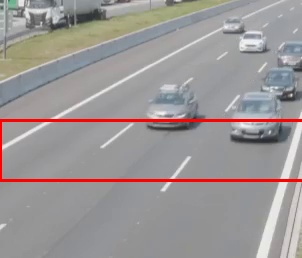


0: 576x640 7 cars, 1 truck, 2942.2ms
Speed: 36.1ms preprocess, 2942.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 640)
1
2


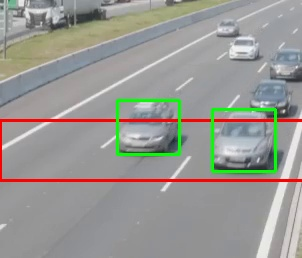


0: 576x640 7 cars, 1 truck, 3305.5ms
Speed: 60.4ms preprocess, 3305.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


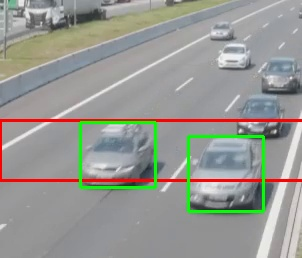


0: 576x640 8 cars, 2758.9ms
Speed: 62.1ms preprocess, 2758.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
3


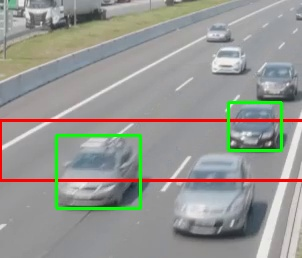


0: 576x640 8 cars, 2850.8ms
Speed: 106.1ms preprocess, 2850.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


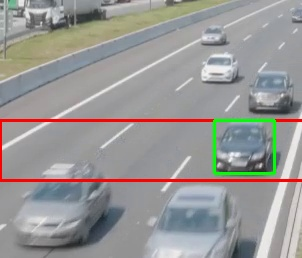


0: 576x640 6 cars, 1 truck, 3560.9ms
Speed: 37.3ms preprocess, 3560.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


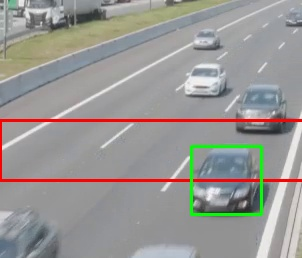


0: 576x640 6 cars, 1 truck, 3599.0ms
Speed: 12.8ms preprocess, 3599.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 640)
4


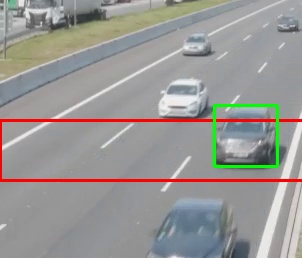


0: 576x640 6 cars, 1 truck, 4510.5ms
Speed: 80.6ms preprocess, 4510.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


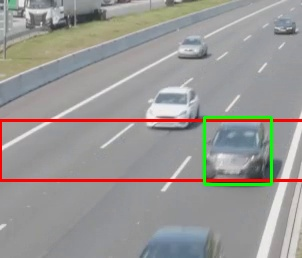


0: 576x640 6 cars, 1 truck, 5728.7ms
Speed: 7.3ms preprocess, 5728.7ms inference, 7.2ms postprocess per image at shape (1, 3, 576, 640)
5


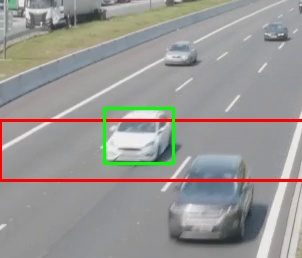


0: 576x640 6 cars, 4680.9ms
Speed: 10.9ms preprocess, 4680.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


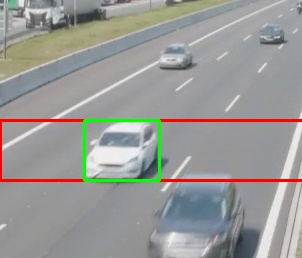


0: 576x640 4 cars, 3976.5ms
Speed: 5.7ms preprocess, 3976.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


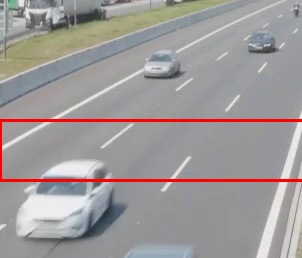


0: 576x640 1 person, 3 cars, 1 motorcycle, 1 truck, 3502.0ms
Speed: 5.6ms preprocess, 3502.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


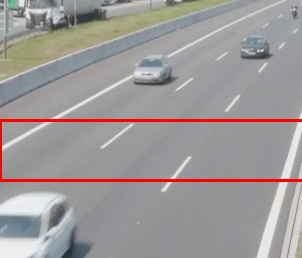

In [ ]:
car_set = []
INSET_THRESHOLD = 8
car_sum = 0
pictures = []
for i in range(len(frame_list)):
    if i % 3 >= 1:
        continue
    f = frame_list[i]
    results = ret = model(f)
    #yoloのホームページより targetどれがどれに対応するかは学習済み
    target = { 2:"car",  5:"bus", 7:"truck", 3:"motorcycle", 1:"bicycle" }
    cars = [car for car in results[0].boxes if int(car.cls[0].item()) in target] 

    # 検出結果の表示用にコピー
    f_view = copy.copy(f)
    # カウントする範囲を描画
    cv2.rectangle(f_view,(0,WINDOW_START), (320, WINDOW_END), color=(0, 0, 255),thickness=2)
    pre_car_set = car_set
    car_set = []
    
    #検知範囲の限定
    for car in cars:
        bbox = {}
        bbox["x1"] = car.xyxy[0][0].item()
        bbox["y1"] = car.xyxy[0][1].item()
        bbox["x2"] = car.xyxy[0][2].item()
        bbox["y2"] = car.xyxy[0][3].item()
        ypos = round((bbox["y1"]+bbox["y2"])/2)
        if ypos >= WINDOW_START and ypos <= WINDOW_END:
            # 同じフレームで2重カウントしてなかったら追加
            inSet = False
            car = Car(bbox, f)
            for c in car_set:
                if car.compare(c) < INSET_THRESHOLD:
                    inSet = True
            if not inSet:
                car_set.append(car)
                # 描画
                cv2.rectangle(
                    f_view,
                    (round(bbox["x1"]), round(bbox["y1"])),
                    (round(bbox["x2"]), round(bbox["y2"])),
                    color=(0, 255, 0),
                    thickness=2,
                )
                # 前フレームにもいなかったら新しい車としてcar_sumを1増やす
                inSet = False
                for c in pre_car_set:
                    if car.compare(c) < INSET_THRESHOLD:
                        inSet = True
                if not inSet:
                    car_sum += 1
                    #通過した車が何台目かカウント
                    print(car_sum)
    imshow(f_view)
    a = cv2.cvtColor(copy.copy(f_view), cv2.COLOR_BGR2RGB)
    pictures.append(fromarray(a))
#     break